In [1]:
import requests
import json
import csv
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [2]:
url = 'https://api.nytimes.com/svc/mostpopular/v2/viewed/1.json?api-key=EYIHqTkNifFDLOyOBpMteduU1ArREeos'

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print(json.dumps(data, indent=4))

else:
    print("Could not retrieve data, sorry! Error code " + str(response.status_code))


{
    "status": "OK",
    "copyright": "Copyright (c) 2024 The New York Times Company.  All Rights Reserved.",
    "num_results": 20,
    "results": [
        {
            "uri": "nyt://article/68fc75b6-dc69-5547-bf1b-14ed6799ec0a",
            "url": "https://www.nytimes.com/2024/08/16/upshot/polls-trump-harris.html",
            "id": 100000009633333,
            "asset_id": 100000009633333,
            "source": "New York Times",
            "published_date": "2024-08-16",
            "updated": "2024-08-16 09:43:11",
            "section": "The Upshot",
            "subsection": "",
            "nytdsection": "the upshot",
            "adx_keywords": "Polls and Public Opinion;Presidential Election of 2024;United States Politics and Government;Trump, Donald J;Harris, Kamala D;Biden, Joseph R Jr",
            "column": null,
            "byline": "By Nate Cohn",
            "type": "Article",
            "title": "The Polls Have Shifted Toward Harris. Is It Real, or Something Else?"

In [3]:
for item in data['results']:
    title = item.get('title', 'No title available')
    adx_keywords = item.get('adx_keywords', 'No keywords available')
    abstract = item.get('abstract', 'No abstract available')

    print(f'Title: {title}')
    print(f'Keywords: {adx_keywords}')
    print(f'Abstract: {abstract}')
    print('----------------------')    

Title: The Polls Have Shifted Toward Harris. Is It Real, or Something Else?
Keywords: Polls and Public Opinion;Presidential Election of 2024;United States Politics and Government;Trump, Donald J;Harris, Kamala D;Biden, Joseph R Jr
Abstract: A review of the Trump team’s critique of our surveys, and the surprising fact that a lot of people don’t seem to remember how they voted.
----------------------
Title: Secret Service Pulls From Biden’s Protective Team to Guard Trump
Keywords: Assassinations and Attempted Assassinations;Presidential Election of 2024;United States Politics and Government;Trump, Donald J;Biden, Joseph R Jr;Cheatle, Kimberly A;Secret Service;Butler (Pa)
Abstract: In the aftermath of an assassination attempt last month, the agency has shifted members of President Biden’s protective team to the Trump campaign.
----------------------
Title: Trump Has Opened the Pathway to Reform
Keywords: Conservatism (US Politics);United States Politics and Government;Presidential Electio

In [4]:
keywords = ['crypto', 'cryptocurrency', 'bitcoin', 'ethereum', 'blockchain', 'nft', 'decentralized', 'defi', 'metaverse', 'web3']

def contains_keywords(text, keywords):
    # Convert text to lowercase and check if any keyword is present
    return any(keyword.lower() in text.lower() for keyword in keywords)

# Open a CSV file to write the filtered results
with open('filtered_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Title', 'ADX Keywords', 'Abstract'])  # Write the header row

    # Iterate over each item in the JSON data
    for item in data['results']:
        title = item.get('title', '')
        adx_keywords = item.get('adx_keywords', '')
        abstract = item.get('abstract', '')

        # Check if any of the keywords are in title, adx_keywords, or abstract
        if (contains_keywords(title, keywords) or
            contains_keywords(adx_keywords, keywords) or
            contains_keywords(abstract, keywords)):
            
            # If keywords are found, write the row to the CSV file
            writer.writerow([title, adx_keywords, abstract])


                                               Title  \
0  Trump Made $300,000 for Endorsing Bible, Finan...   

                                        ADX Keywords  \
0  United States Politics and Government;Presiden...   

                                            Abstract  
0  Donald J. Trump also listed $100 million in li...  
                                               Title  \
0  Trump Made $300,000 for Endorsing Bible, Finan...   

                                        ADX Keywords  \
0  United States Politics and Government;Presiden...   

                                            Abstract  overall_sentiment  
0  Donald J. Trump also listed $100 million in li...           0.073067  
                                               Title  \
0  Trump Made $300,000 for Endorsing Bible, Finan...   

                                        ADX Keywords  \
0  United States Politics and Government;Presiden...   

                                            Abstract  overall_se

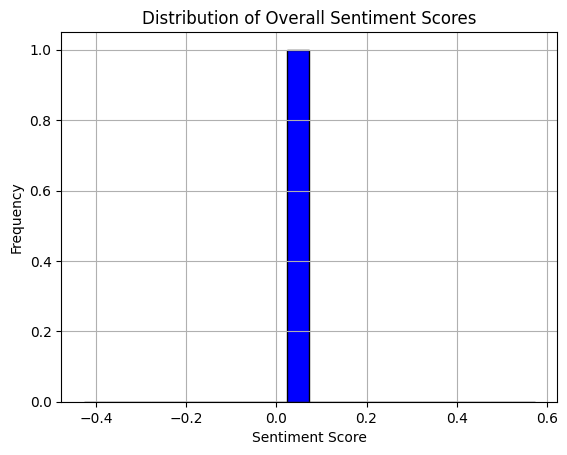

In [5]:
df = pd.read_csv('filtered_output.csv')
print(df)

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Return the compound score

# Apply sentiment analysis to each of the columns and calculate an overall sentiment score
df['title_sentiment'] = df['Title'].apply(analyze_sentiment)
df['keywords_sentiment'] = df['ADX Keywords'].apply(analyze_sentiment)
df['abstract_sentiment'] = df['Abstract'].apply(analyze_sentiment)

# Calculate an average sentiment score for each article
df['overall_sentiment'] = df[['title_sentiment', 'keywords_sentiment', 'abstract_sentiment']].mean(axis=1)

# Display the results
print(df[['Title', 'ADX Keywords', 'Abstract', 'overall_sentiment']])


# Function to categorize the impact
def categorize_impact(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the categorization
df['impact'] = df['overall_sentiment'].apply(categorize_impact)

# Display the categorized results
print(df[['Title', 'ADX Keywords', 'Abstract', 'overall_sentiment', 'impact']])


# Count the number of articles in each impact category
impact_counts = df['impact'].value_counts()

print("Impact Distribution:")
print(impact_counts)

# Visualize the distribution of sentiment

df['overall_sentiment'].hist(bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Overall Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

